# Unsupervised Learning - SCADI Dataset
Apply clustering and dimension reduction algorithms

## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, mean_squared_error, silhouette_score,
    adjusted_rand_score, adjusted_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
)
import time
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.models import Sequential
from keras.layers import AveragePooling2D, Conv2D, Dense, Flatten, Reshape
from keras.utils import to_categorical
import random
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

## Load data and normalize features

In [2]:
data = pd.read_csv('data/scadi-dataset/scadi.csv')
train_y = np.array(data['Classes'])
std_scaler = StandardScaler()
data = data.drop(columns=['Classes'])
train_X = std_scaler.fit_transform(data.values)
train_X.shape, train_y.shape

((70, 205), (70,))

## Part I: Run clustering algorithms

In [3]:
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 6  # Set to an integer (discovered best n_clusters) or a list of integers (to discover best n_clusters)

In [4]:
def constuct_clustering_model(clustering_algorithm, n_clusters):
    if clustering_algorithm == 'k_means':
        clustering_model = KMeans(random_state=0, n_clusters=n_clusters)
    elif clustering_algorithm == 'em':
        clustering_model = GaussianMixture(random_state=0, n_components=n_clusters)
    return clustering_model

def run_clustering_algorithm(clustering_algorithm, n_clusters, train_X):
    if isinstance(n_clusters, int):
        clustering_model = constuct_clustering_model(clustering_algorithm, n_clusters)
        start_time = time.time()
        clustering_model.fit(train_X)
        end_time = time.time()
        print('-----------------------------------------------------------------------')
        print('Result for n_clusters: {}'.format(n_clusters))
        print('Time elapsed (in seconds): {}'.format(end_time - start_time))
        print('Silhouette score: {}'.format(silhouette_score(train_X, clustering_model.predict(train_X), metric='euclidean')))
        if clustering_algorithm == 'k_means':
            print('Sum of squared distances of samples to their closest cluster center: {}'
                  .format(clustering_model.inertia_))
        elif clustering_algorithm == 'em':
            print('AIC: {0}, and BIC: {1}'.format(clustering_model.aic(train_X), clustering_model.bic(train_X)))
    elif isinstance(n_clusters, list):
        sses = []
        aics = []
        bics = []
        silhouette_scores = []
        for n in n_clusters:
            clustering_model = constuct_clustering_model(clustering_algorithm, n)
            start_time = time.time()
            clustering_model.fit(train_X)
            end_time = time.time()
            print('-----------------------------------------------------------------------')
            print('Result for n_clusters: {}'.format(n))
            print('Time elapsed (in seconds): {}'.format(end_time - start_time))
            silhouette = silhouette_score(train_X, clustering_model.predict(train_X), metric='euclidean')
            print('Silhouette score: {}'.format(silhouette))
            silhouette_scores.append(silhouette)
            if clustering_algorithm == 'k_means':
                print('Sum of squared distances of samples to their closest cluster center: {}'
                      .format(clustering_model.inertia_))
                sses.append(clustering_model.inertia_)
            elif clustering_algorithm == 'em':
                aic = clustering_model.aic(train_X)
                bic = clustering_model.bic(train_X)
                print('AIC: {0}, and BIC: {1}'.format(aic, bic))
                aics.append(aic)
                bics.append(bic)
        plt.figure(random.randint(0, 10000))
        plt.plot(n_clusters, silhouette_scores)
        plt.title('Silhouette score v.s. k')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.show()
        if clustering_algorithm == 'k_means':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, sses)
            plt.title('Sum of squared distances of samples to their closest cluster center')
            plt.xlabel('k')
            plt.ylabel('Sum Squared Error')
            plt.show()
        elif clustering_algorithm == 'em':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, aics, label='AIC')
            plt.plot(n_clusters, bics, label='BIC')
            plt.legend(loc='lower right')
            plt.title('AIC or BIC v.s. k')
            plt.xlabel('k')
            plt.ylabel('AIC or BIC')
            plt.show()
    else:
        raise ValueError('Invalid argument n_clusters: {}. Only int or list of int supported!'.format(n_clusters))
    return clustering_model

In [5]:
def eval_clustering_result(train_y, pred_y):
    print('Adjusted rand score: {}'.format(adjusted_rand_score(train_y, pred_y)))
    print('Adjusted mutual information score: {}'.format(adjusted_mutual_info_score(train_y, pred_y)))
    print('Homogeneity score: {}'.format(homogeneity_score(train_y, pred_y)))
    print('Completeness score: {}'.format(completeness_score(train_y, pred_y)))
    print('V-measure score: {}'.format(v_measure_score(train_y, pred_y)))

In [6]:
def viz(X, y):
    # Visulize dimensionality reduction result against true or predicted labels in 2D
    if X.shape[1] > 50:
        X = PCA(n_components=50).fit_transform(X)
    if X.shape[0] > 100:
        X, y = sample_rows(X, y, 100)
    embedded_X = TSNE(random_state=0, n_components=2).fit_transform(X)
    df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
    df_tsne['label'] = y
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

-----------------------------------------------------------------------
Result for n_clusters: 6
Time elapsed (in seconds): 0.03611326217651367
Silhouette score: 0.19830428021455912
AIC: 101050.64275343335, and BIC: 388689.3965925976
Adjusted rand score: 0.5059723047212595
Adjusted mutual information score: 0.5464495600695365
Homogeneity score: 0.6217089056763576
Completeness score: 0.5971298322213406
V-measure score: 0.6091715384389044


(array([3, 3, 3, 3, 3, 2, 1, 0, 4, 2, 4, 5, 4, 5, 4, 1, 0, 3, 0, 4, 5, 2,
        0, 3, 3, 4, 2, 3, 0, 3, 5, 2, 1, 3, 3, 3, 5, 4, 3, 3, 3, 0, 0, 5,
        0, 4, 0, 0, 3, 0, 0, 4, 1, 3, 3, 0, 0, 3, 3, 3, 3, 4, 4, 0, 0, 0,
        0, 3, 1, 3]),
 GaussianMixture(n_components=6, random_state=0))

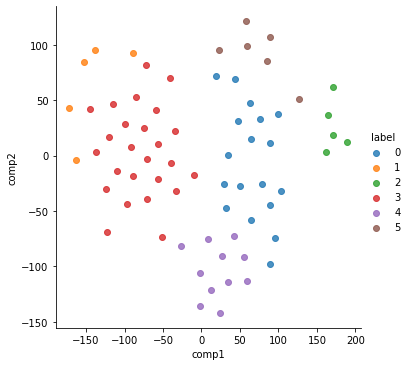

In [7]:
def clustering_all_in_one(clustering_algorithm, n_clusters, train_X, train_y, plot=True):
    # Run clustering algorithm
    clustering_model = run_clustering_algorithm(clustering_algorithm, n_clusters, train_X)
    # Evaluate clustering result against true labels
    pred_y = clustering_model.predict(train_X)
    eval_clustering_result(train_y, pred_y)
    # Visulize clustering result in 2D
    if plot:
        viz(train_X, pred_y)
    return pred_y, clustering_model

clustering_all_in_one(clustering_algorithm, n_clusters, train_X, train_y)

## Part II: Apply dimensionality reduction algorithms

In [8]:
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 6  # For random_projection, set to 'auto'

In [9]:
def construct_dr_model(dr_algorithm, n_components):
    if dr_algorithm == 'pca':
        dr_model = PCA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'ica':
        dr_model = FastICA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'random_projection':
        dr_model = GaussianRandomProjection(random_state=0, n_components=n_components, eps=0.5)
    elif dr_algorithm == 'lda':
        dr_model = LinearDiscriminantAnalysis(n_components=n_components)
    return dr_model

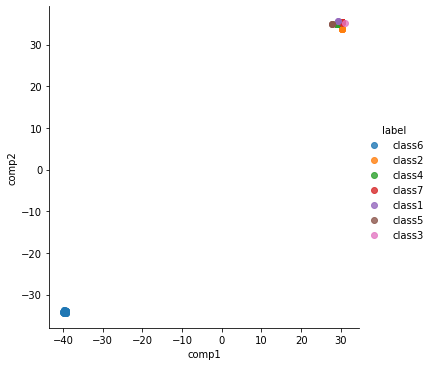

In [10]:
def dr_all_in_one(dr_algorithm, n_components, train_X, train_y):
    # Apply dimensionality reduction algorithm
    dr_model = construct_dr_model(dr_algorithm, n_components)
    reduced_X = dr_model.fit_transform(train_X, train_y)
    # Evaluate MSE between original data and reconstructed data (if possible)
    if dr_algorithm == 'pca' or dr_algorithm == 'ica':
        reconstructed_X = dr_model.inverse_transform(reduced_X)
        print('MSE between original data and reconstructed data: {}'
              .format(mean_squared_error(train_X, reconstructed_X)))
    return reduced_X, dr_model

if n_components is None:
    if dr_algorithm == 'pca':
        _, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
        # Determine n_components that could keep 95% of the variance
        cumsum = np.cumsum(dr_model.explained_variance_ratio_)
        min_n_components = np.argmax(cumsum >= 0.95) + 1
        print('To keep 95% of the variance, reduced dimension needs to be no smaller than {}'
              .format(min_n_components))
    elif dr_algorithm == 'ica':
        ns = list(range(2, 71))
        avg_kurtosis = []
        min_kurtosis = []
        max_kurtosis = []
        avg_dw = []
        min_dw = []
        max_dw = []
        for n in ns:
            reduced_X, _ = dr_all_in_one(dr_algorithm, n, train_X, train_y)
            kurts = np.absolute(stats.kurtosis(reduced_X, fisher=True))
            avg_kurtosis.append(np.mean(kurts))
            min_kurtosis.append(np.min(kurts))
            max_kurtosis.append(np.max(kurts))
            dws = durbin_watson(reduced_X)
            avg_dw.append(np.mean(dws))
            min_dw.append(np.min(dws))
            max_dw.append(np.max(dws))
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, avg_kurtosis, label='Avg Kurtosis')
        plt.plot(ns, min_kurtosis, label='Min Kurtosis')
        plt.plot(ns, max_kurtosis, label='Max Kurtosis')
        plt.xlabel('n_components')
        plt.ylabel('Kurtosis')
        plt.title('Kurtosis v.s. n_components')
        plt.legend(loc='upper left')
        plt.show()
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, avg_dw, label='Avg Durbin-Watson')
        # plt.plot(ns, min_dw, label='Min Durbin-Watson')
        plt.plot(ns, max_dw, label='Max Durbin-Watson')
        plt.xlabel('n_components')
        plt.ylabel('Durbin-Watson')
        plt.title('Durbin-Watson v.s. n_components')
        plt.legend(loc='upper right')
        plt.show()
    elif dr_algorithm == 'lda':
        ns = list(range(2, 7))
        explained_variance_ratios = []
        for n in ns:
            _, dr_model = dr_all_in_one(dr_algorithm, n, train_X, train_y)
            explained_variance_ratios.append(np.sum(dr_model.explained_variance_ratio_))
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, explained_variance_ratios)
        plt.xlabel('n_components')
        plt.ylabel('Explained variance ratio')
        plt.title('Explained variance ratio v.s. n_components')
        plt.show()
else:
    reduced_X, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
    if dr_algorithm == 'random_projection':
        print('To keep the distortion within eps = 0.5, reduced dimension needs to be no smaller than {}'
              .format(dr_model.n_components_))
    viz(reduced_X, train_y)

## Part III: Run clustering algorithm after dimensionality reduction

In [11]:
# Dimensionality reduction settings
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 6

# Clustering settings
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 5  # Set to an integer (discovered best n_clusters) or a list (to discover best n_clusters)

In [12]:
if dr_algorithm == 'lda':
    lda_train_X, lda_test_X, lda_train_y, lda_test_y = train_test_split(
        train_X, train_y, test_size=0.2, random_state=0)
    lda_reduced_train_X, dr_model = dr_all_in_one(dr_algorithm, n_components, lda_train_X, lda_train_y)
    lda_reduced_test_X = dr_model.transform(lda_test_X)
    _, clustering_model = clustering_all_in_one(
        clustering_algorithm, n_clusters, lda_reduced_train_X, lda_train_y, plot=False)
    pred_y = clustering_model.predict(lda_reduced_test_X)
    eval_clustering_result(lda_test_y, pred_y)
else:
    reduced_X, _ = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
    clustering_all_in_one(clustering_algorithm, n_clusters, reduced_X, train_y)

-----------------------------------------------------------------------
Result for n_clusters: 5
Time elapsed (in seconds): 0.005947113037109375
Silhouette score: 0.7922623267671484
AIC: 589.0396401886333, and BIC: 870.563525200819
Adjusted rand score: 0.905983684247559
Adjusted mutual information score: 0.9221254350183374
Homogeneity score: 0.8743617288106499
Completeness score: 1.0
V-measure score: 0.9329701042983457
Adjusted rand score: 0.09946714031971583
Adjusted mutual information score: 0.152882579928295
Homogeneity score: 0.3129646336796807
Completeness score: 0.5913378741765681
V-measure score: 0.4093051596446746
